In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
img = cv2.imread("14-BANANAAA!!!.png", cv2.IMREAD_COLOR)

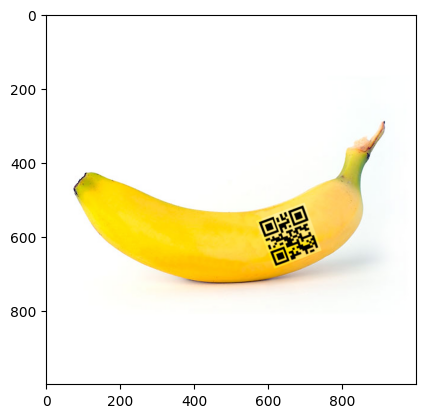

In [3]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

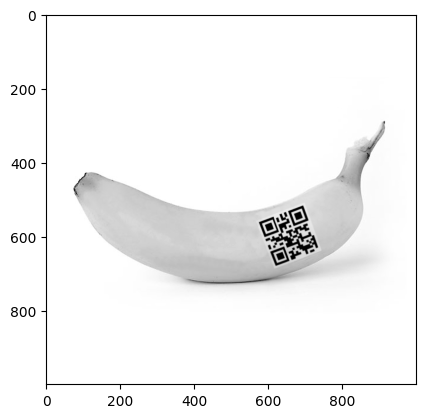

In [4]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray")

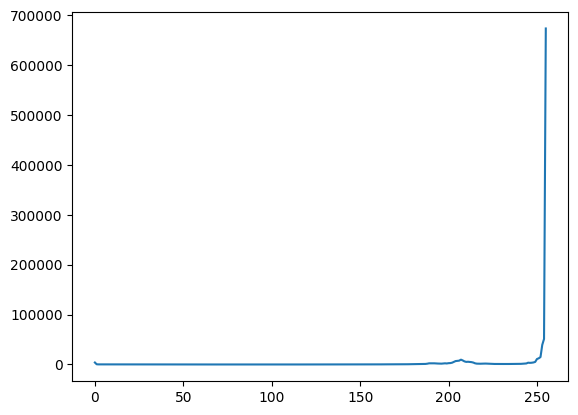

In [5]:
histogram = cv2.calcHist([img_gray], [0], None, [256], [0, 256])

plt.plot(histogram)

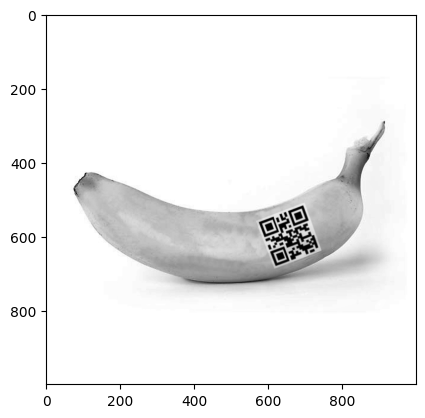

In [6]:
equalized_image = cv2.createCLAHE(clipLimit=2, tileGridSize=(10, 10))
equalized_image = equalized_image.apply(img_gray)
plt.imshow(equalized_image, cmap="gray")

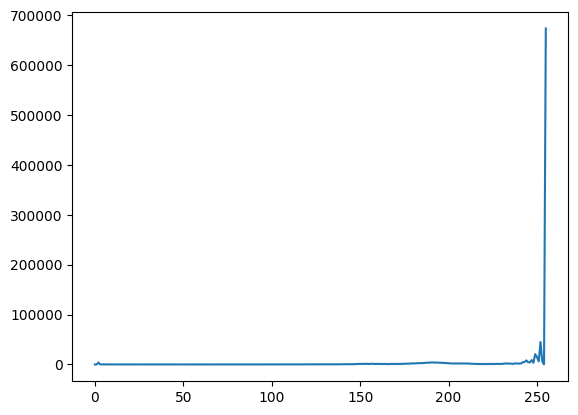

In [7]:
hist = cv2.calcHist([equalized_image], [0], None, [256], [0, 256])
plt.plot(hist)

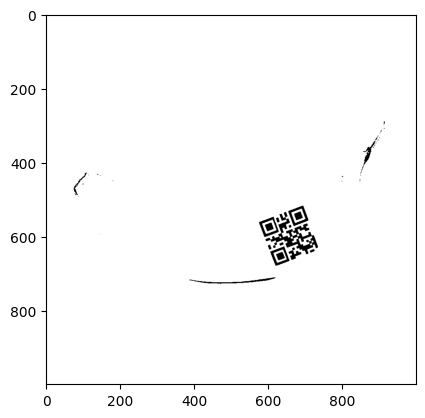

In [18]:
_, binary_image = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

# Display the converted image
plt.imshow(binary_image, cmap="gray")

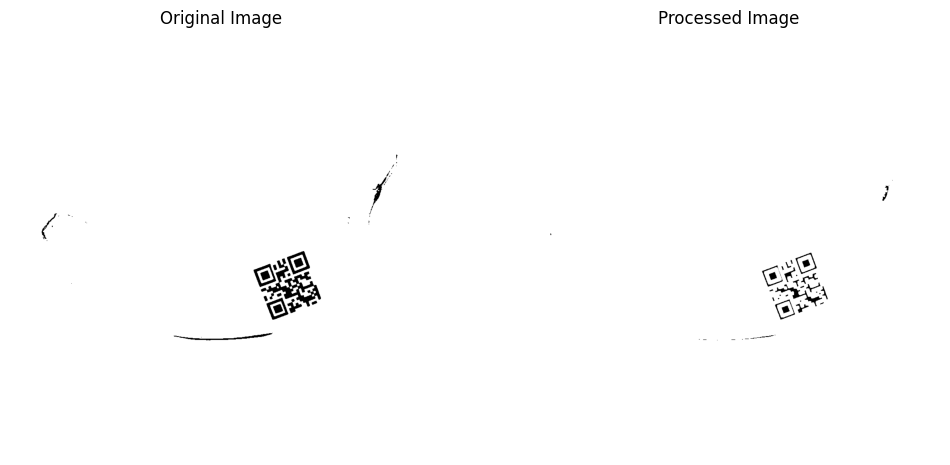

In [64]:
# Perform opening with a small kernel (adjust size as needed)
kernel = np.ones((2, 2), np.uint8)
dilation = cv2.dilate(binary_image, kernel, iterations=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(dilation, cv2.COLOR_BGR2RGB))
ax2.set_title('Processed Image')
ax2.axis('off')

plt.show()

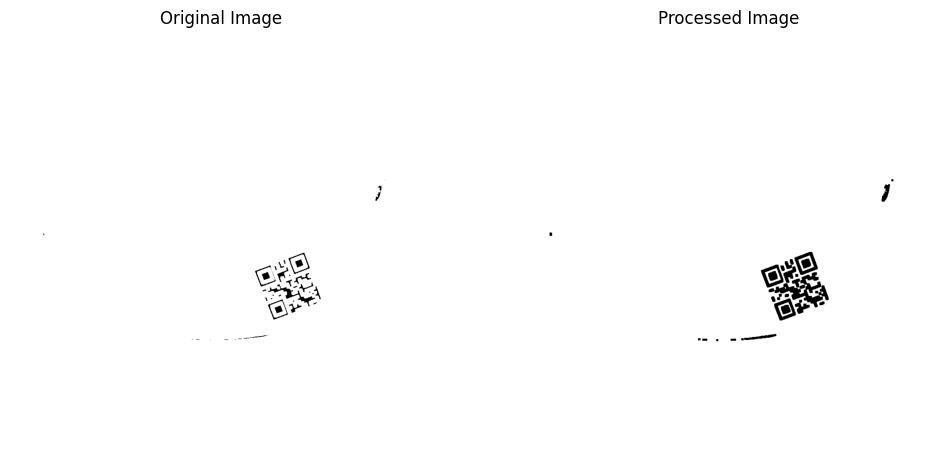

In [65]:
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(dilation, kernel, iterations=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(cv2.cvtColor(dilation, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
ax2.set_title('Processed Image')
ax2.axis('off')

plt.show()

Estimated Rotation Angle: 33.000003814697266


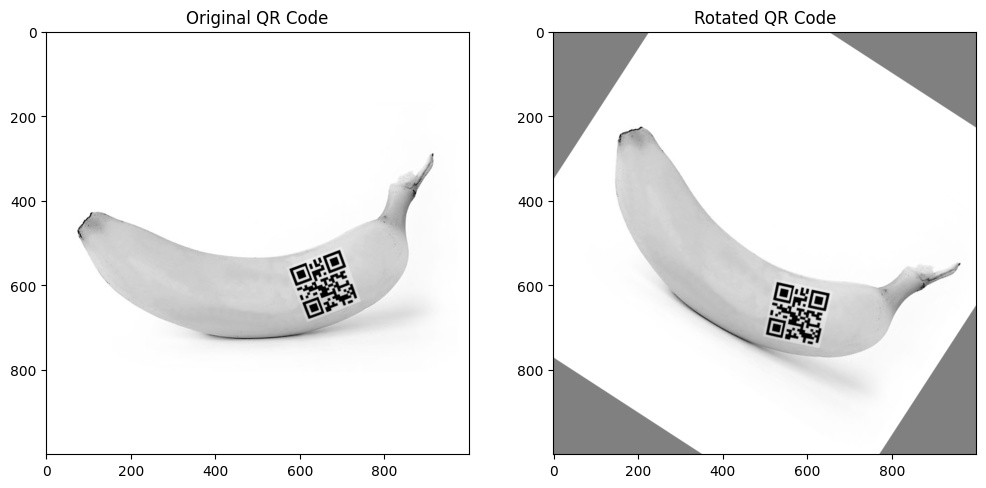

In [73]:
# Step 1: Edge Detection using Canny edge detector
edges = cv2.Canny(img_rgb, 50, 150, apertureSize=3)

# Step 2: Apply Hough Transform to detect lines
lines = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=100)

if lines is not None:
    # Calculate angles of detected lines and filter out lines with extreme angles
    angles = []
    for line in lines:
        rho, theta = line[0]
        angle = np.degrees(theta)
        angles.append(angle)

    # Filter out lines based on angle threshold (e.g., exclude lines with extreme angles)
    filtered_angles = [angle for angle in angles if abs(angle) < 90]

    if filtered_angles:
        # Compute the median angle of remaining lines
        rotation_angle = 90 - np.median(filtered_angles)
        print("Estimated Rotation Angle:", rotation_angle)
        if angle == 90:
            pass
        else:
            # Rotate the image to make the QR code horizontal (adjust angle if needed)
            height, width = img_gray.shape[:2]
            rotation_center = (width // 2, height // 2)  # Center of the image
            rotation_matrix = cv2.getRotationMatrix2D(rotation_center, -rotation_angle, 1)

            # Apply rotation to the image (with white background)
            rotated_image = cv2.warpAffine(img_gray, rotation_matrix, (width, height),
                                        flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=128)

            # Display the original and rotated images
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.imshow(img_gray, cmap='gray')
            plt.title('Original QR Code')

            plt.subplot(1, 2, 2)
            plt.imshow(rotated_image, cmap='gray')
            plt.title('Rotated QR Code')

            plt.show()

            img = rotated_image
    else:
        print("No suitable lines detected. Adjust Hough Transform parameters or image content.")
else:
    print("No lines detected. Adjust Hough Transform parameters.")

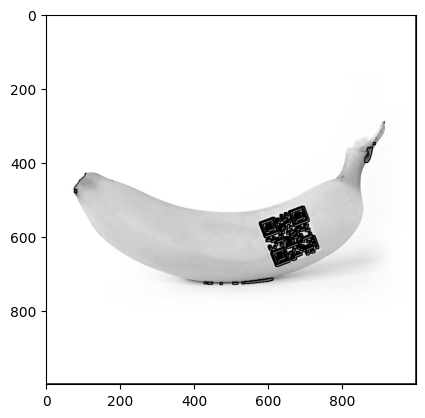

In [68]:
contours, _ = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
contour_image = cv2.drawContours(img_gray.copy(), contours, -1, (0, 255, 0), 2)

# Display the image with contours
plt.imshow(contour_image, cmap='gray');

In [ ]:
qr_contour = None
qr_angle = 0
for contour in contour_image:
    # Calculate the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Check if the aspect ratio of the bounding box is close to 1 (square-like)
    aspect_ratio = float(w) / h
    if 0.8 < aspect_ratio < 1.2:
        # Calculate the rotation angle of the minimum area bounding box
        rect = cv2.minAreaRect(contour)
        angle = rect[2]

        # Check if the angle is within a reasonable range for a QR code
        if abs(angle) < 45:
            qr_contour = contour
            qr_angle = angle
            break

if qr_contour is None:
    print("No QR code detected in the image.")
    # return equalized_image

print("QR code tilt angle:", qr_angle, "degrees")

if abs(qr_angle) > 5:
    print("The QR code is tilted. Rotating the image to fix the orientation.")
    # Rotate the image to straighten the QR code
    rows, cols = img_gray.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), -qr_angle, 1)
    rotated_image = cv2.warpAffine(img_gray, rotation_matrix, (cols, rows))
    plt.imshow(rotated_image, cmap='gray');
else:
    print("The QR code is not tilted.")

No QR code detected in the image.
QR code tilt angle: 0 degrees
The QR code is not tilted.


The image has colors other than 0 and 255. Converting to pure black and white.


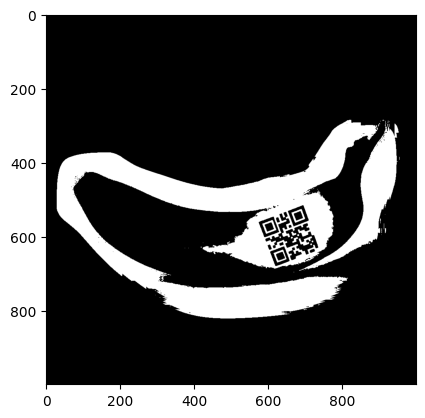

In [ ]:
has_intermediate_colors = False
for i in range(1, 255):
    if histogram[i] > 0:
        has_intermediate_colors = True
        break

# Apply thresholding to convert the image
binary_image = cv2.adaptiveThreshold(
    src=img,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,  # read: https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gaa42a3e6ef26247da787bf34030ed772c
    thresholdType=cv2.THRESH_BINARY,
    blockSize=201,  # NxN block size (odd) to perform adaptive threshold on
    C=-7  # Constant subtracted from the mean or weighted mean
)

# Convert the image to pure black and white if it has intermediate colors
if has_intermediate_colors:
    print("The image has colors other than 0 and 255. Converting to pure black and white.")

    # Display the converted image
    plt.imshow(binary_image, cmap='gray', vmin=0, vmax=255);
else:
    print("The image has only 0 and 255 colors (pure black and pure white).")

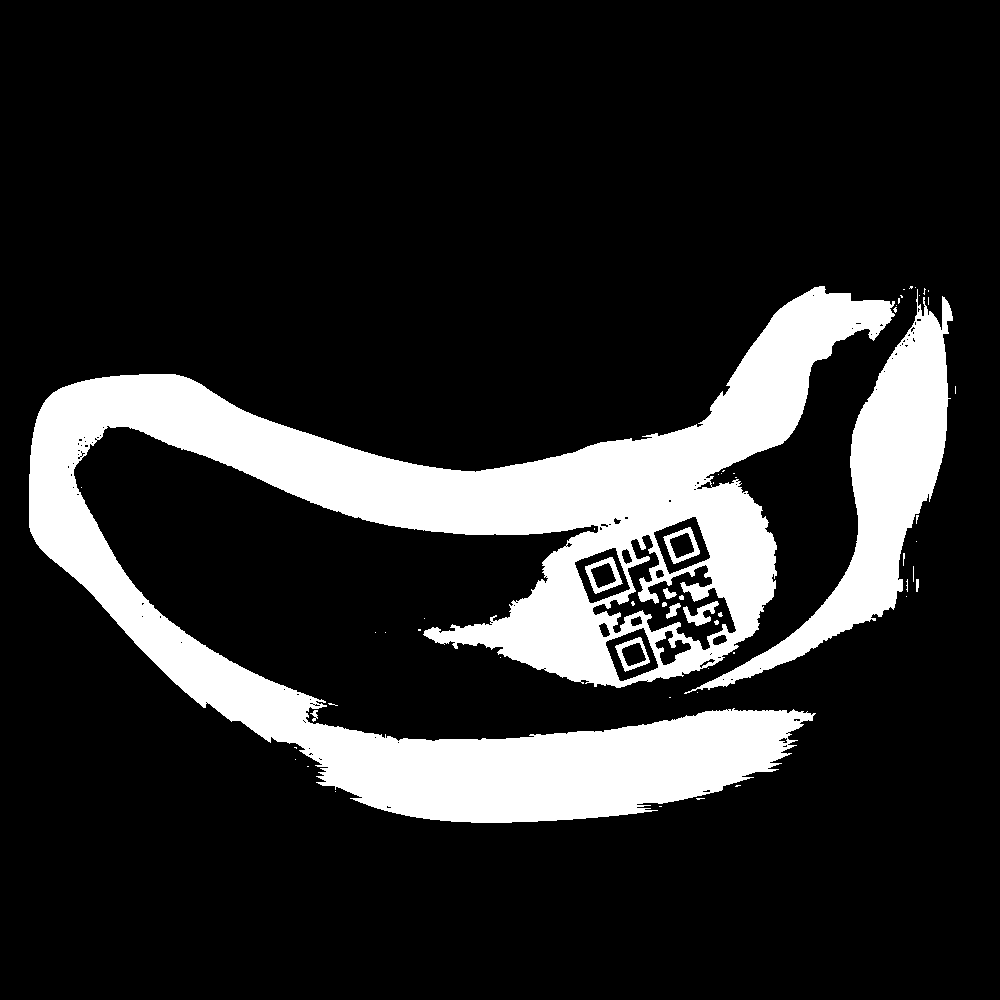

In [ ]:
# thresh = cv2.adaptiveThreshold(binary_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Optional noise reduction (e.g., Gaussian blurring)
# blur = cv2.GaussianBlur(thresh, (5, 5), 0)  # Adjust kernel size as needed

# Edge detection
edges = cv2.Canny(binary_image, 100, 200)  # Adjust thresholds as needed

# Optional morphological operations (e.g., opening)
# kernel = np.ones((3, 3), np.uint8)
# opening = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)  # Adjust kernel size as needed

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Option 1: Filter contours based on aspect ratio (without polygon approximation)
qr_code_contour = None
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = abs(w / h)
    if aspect_ratio >= 0.8 and aspect_ratio <= 1.2 and len(cnt) >= 4:  # Adjust thresholds as needed
        qr_code_contour = cnt
        break

# Option 2: Filter contours based on aspect ratio and refine with polygon approximation
# qr_code_contour = None
# for cnt in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     aspect_ratio = abs(w / h)
#
#     # Define epsilon for polygon approximation
#     epsilon = 0.01 * cv2.arcLength(cnt, True)
#     approx = cv2.approxPolyDP(cnt, epsilon, True)
#
#     if aspect_ratio >= 0.8 and aspect_ratio <= 1.2 and len(approx) >= 4:  # Adjust thresholds as needed
#         qr_code_contour = approx
#         break

# Check if a potential QR code contour was found
if qr_code_contour is not None:
    # Get a tighter bounding box (based on contour or polygon approximation)
    x, y, w, h = cv2.boundingRect(qr_code_contour)  # Use for original bounding box
    # x, y, w, h = cv2.boundingRect(approx)  # Use for polygon approximation (if enabled)

    # Define zoom factor
    zoom_factor = 3

    # Calculate zoomed-in region dimensions
    new_width = int(w * zoom_factor)
    new_height = int(h * zoom_factor)

    # Crop the image
    cropped_image = binary_image[y:y + h, x:x + w]
    zoomed_image = cv2.resize(cropped_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Display results (optional)
    cv2_imshow(binary_image)
    cv2_imshow(zoomed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

else:
    print("No potential QR code region detected in the image.")

In [ ]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(binary_image):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(binary_image[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = binary_image.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(binary_image)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(binary_image)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = binary_image.shape[1] - col_index
            break
    if end_col != -1:
        break

print(start_row, end_row, start_col, end_col)

0 1000 0 1000


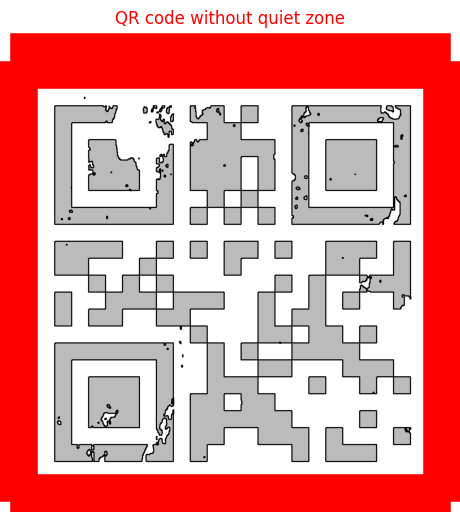

In [ ]:
qr_no_quiet_zone = contour_image[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
fig.get_axes()[0].spines[:].set_color('red');
fig.get_axes()[0].spines[:].set_linewidth(40);
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y = 1.15, color='red');
plt.imshow(qr_no_quiet_zone, cmap='gray');

In [ ]:
size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1

print(size)

0


In [ ]:
# Therefore the grid cell size is..
grid_cell_size = round(size/7)
print(grid_cell_size)

0
